### Cat and Dog Sound Analysis RNN

https://www.kaggle.com/datasets/mmoreaux/audio-cats-and-dogs?resource=download-directory


In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten


In [3]:
train_dir = "cats_dogs/train"
test_dir = "cats_dogs/test"

In [4]:
"""
# Define paths
# This was used as the fileset we got was messed up, this copied to audios not in the folder to the correct folders atomatically
# This is no longer needed after the first rin

def move_files_to_classes(directory):

    #Move unsorted files into their respective class subdirectories
    #based on the filenames (e.g., 'cat_*.wav' or 'dog_*.wav').

    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        if os.path.isfile(file_path):  # Ensure it's a file, not a folder
            if file.startswith("cat"):
                os.rename(file_path, os.path.join(directory, "cat", file))
            elif file.startswith("dog"):
                os.rename(file_path, os.path.join(directory, "dog", file))

# Move files in train and test directories
move_files_to_classes(train_dir)
move_files_to_classes(test_dir)

# Verify train directory
print("Files in train_dir after sorting:", os.listdir(train_dir))
# Verify test directory
print("Files in test_dir after sorting:", os.listdir(test_dir))

# Check subdirectories in train and test
print("Subdirectories in train_dir:", os.listdir(train_dir))
print("Subdirectories in test_dir:", os.listdir(test_dir))

# Check the contents of the `cat` and `dog` folders
print("\nFiles in train_dir/cat:", os.listdir(os.path.join(train_dir, "cat")))
print("Files in train_dir/dog:", os.listdir(os.path.join(train_dir, "dog")))
print("\nFiles in test_dir/cat:", os.listdir(os.path.join(test_dir, "cat")))
print("Files in test_dir/dog:", os.listdir(os.path.join(test_dir, "dog")))

"""


'\n# Define paths\n# This was used as the fileset we got was messed up, this copied to audios not in the folder to the correct folders atomatically\n# This is no longer needed after the first rin\n\ndef move_files_to_classes(directory):\n\n    #Move unsorted files into their respective class subdirectories\n    #based on the filenames (e.g., \'cat_*.wav\' or \'dog_*.wav\').\n\n    for file in os.listdir(directory):\n        file_path = os.path.join(directory, file)\n        if os.path.isfile(file_path):  # Ensure it\'s a file, not a folder\n            if file.startswith("cat"):\n                os.rename(file_path, os.path.join(directory, "cat", file))\n            elif file.startswith("dog"):\n                os.rename(file_path, os.path.join(directory, "dog", file))\n\n# Move files in train and test directories\nmove_files_to_classes(train_dir)\nmove_files_to_classes(test_dir)\n\n# Verify train directory\nprint("Files in train_dir after sorting:", os.listdir(train_dir))\n# Verify te

### Load Data

When working with the audio dataset, I noticed several challenges that required careful preprocessing to ensure the data was suitable for training a deep learning model. First, the audio files varied in length, which is a common issue in audio datasets. Neural networks, especially RNNs, require inputs of fixed length, so I addressed this by padding shorter signals with zeros and truncating longer signals to a standardized length of 16,000 samples (representing 1 second of audio). This ensures that the model receives consistent input, preventing errors during training. 

I also needed to confirm that the dataset was properly organized and balanced. To check for potential class imbalances, I calculated the distribution of `cat` and `dog` labels in both the training and testing datasets. This step is critical because imbalances can bias the model towards predicting the majority class, reducing its ability to generalize. By printing the class distribution, I could identify whether further balancing was necessary. 

Another problem I anticipated was noise or corruption in the audio signals, which could negatively impact the model's performance. To verify the quality of the loaded audio files, I plotted the waveform of the first training and testing samples. This visualization allowed me to inspect the signals and confirm that they were processed correctly, with no significant noise, clipping, or unexpected artifacts. 

Finally, I calculated statistics like the minimum, maximum, and mean signal lengths to ensure that the padding and truncation worked as expected, guaranteeing uniformity across all samples. Each of these steps was designed to address potential data issues upfront, ensuring that the dataset was clean, balanced, and ready for training. This proactive approach minimizes the risk of encountering data-related errors later in the pipeline and sets the stage for building an effective and robust model.

Number of training samples: 210
Number of testing samples: 67

Training class distribution:
  cat: 125 samples
  dog: 85 samples

Testing class distribution:
  cat: 39 samples
  dog: 28 samples

Audio signal details:
  Training data signal length: Min = 16000, Max = 16000, Mean = 16000.0
  Testing data signal length: Min = 16000, Max = 16000, Mean = 16000.0


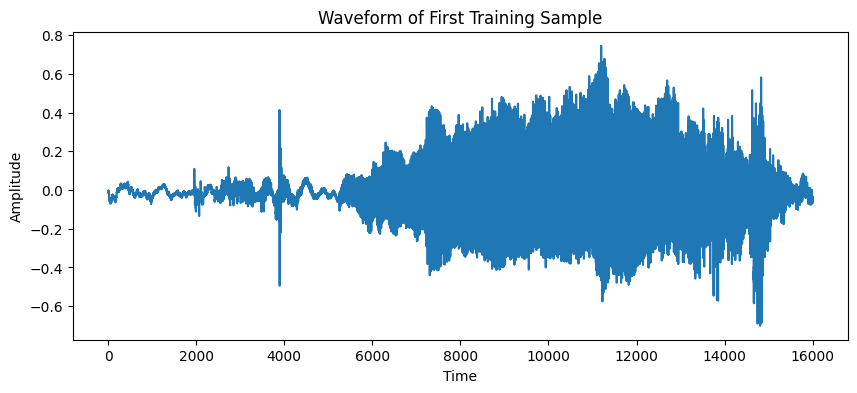

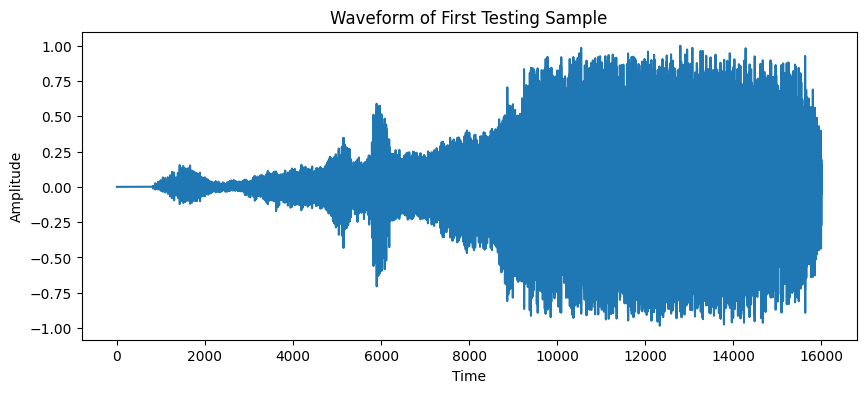

In [5]:


def load_audio_files(directory, target_length=16000):
    """
    Load audio files from the given directory, extract their waveforms,
    and pad/truncate to a fixed length.
    """
    data = []
    labels = []
    for label in os.listdir(directory):  # 'cats' and 'dogs'
        class_path = os.path.join(directory, label)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                if file_path.endswith(".wav"):
                    # Load audio signal
                    signal, sr = librosa.load(file_path, sr=16000)  # Standardize sample rate
                    
                    # Pad or truncate signal
                    if len(signal) < target_length:
                        signal = np.pad(signal, (0, target_length - len(signal)))
                    elif len(signal) > target_length:
                        signal = signal[:target_length]
                    
                    data.append(signal)
                    labels.append(label)
    return np.array(data), labels


# Load training and test data
train_data, train_labels = load_audio_files(train_dir)
test_data, test_labels = load_audio_files(test_dir)

# Print details about the data
print(f"Number of training samples: {len(train_data)}")
print(f"Number of testing samples: {len(test_data)}")

# Check class distribution
from collections import Counter
train_class_distribution = Counter(train_labels)
test_class_distribution = Counter(test_labels)
print("\nTraining class distribution:")
for label, count in train_class_distribution.items():
    print(f"  {label}: {count} samples")

print("\nTesting class distribution:")
for label, count in test_class_distribution.items():
    print(f"  {label}: {count} samples")

# Check lengths of audio signals
train_lengths = [len(signal) for signal in train_data]
test_lengths = [len(signal) for signal in test_data]

print("\nAudio signal details:")
print(f"  Training data signal length: Min = {min(train_lengths)}, Max = {max(train_lengths)}, Mean = {np.mean(train_lengths)}")
print(f"  Testing data signal length: Min = {min(test_lengths)}, Max = {max(test_lengths)}, Mean = {np.mean(test_lengths)}")


# Visualize the waveform of the first training sample
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(train_data[0])
plt.title("Waveform of First Training Sample")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

# Visualize the waveform of the first testing sample
plt.figure(figsize=(10, 4))
plt.plot(test_data[0])
plt.title("Waveform of First Testing Sample")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


We shuffled the data because it is critical to ensure that the model does not learn patterns tied to the sequence of the dataset, which could lead to overfitting or biased performance. By randomizing the order of the samples, we ensured that the model receives a diverse mix of data during training, which helps it generalize better to unseen examples. This decision was particularly important because datasets often have an inherent order, such as all samples of one class being grouped together. Without shuffling, the model might prioritize certain patterns tied to the order rather than focusing on meaningful features in the data. Shuffling also helps ensure that evaluation on the test set provides an accurate measure of the model’s performance without being influenced by the order of the data.

In [6]:
import numpy as np

def shuffle_data(data, labels):
    """
    Shuffle data and labels together.
    """
    # Convert data and labels to NumPy arrays if they are not already
    data = np.array(data)
    labels = np.array(labels)

    # Create indices and shuffle
    indices = np.arange(len(labels))
    np.random.shuffle(indices)
    return data[indices], labels[indices]

# Shuffle training data
train_data, train_labels = shuffle_data(train_data, train_labels)

# Shuffle testing data
test_data, test_labels = shuffle_data(test_data, test_labels)

# Verify first 5 labels
print("\nFirst 5 training labels after shuffling:", train_labels[:5])
print("First 5 testing labels after shuffling:", test_labels[:5])



First 5 training labels after shuffling: ['cat' 'cat' 'dog' 'dog' 'cat']
First 5 testing labels after shuffling: ['dog' 'dog' 'cat' 'cat' 'dog']


We decided to balance the dataset to address the issue of class imbalance, which can negatively impact the model's ability to generalize and perform well on all classes. In an imbalanced dataset, the model tends to favor the majority class (e.g., cat) because it sees more samples of that class during training. This can lead to biased predictions and poor performance on the minority class (e.g., dog).

To resolve this, we undersampled the majority class to match the number of samples in the minority class. This approach ensures that both classes are equally represented in the training data, giving the model an equal opportunity to learn from each class. While undersampling reduces the amount of data available from the majority class, it helps prevent the model from becoming biased.

Additionally, we shuffled the balanced dataset to randomize the order of samples, ensuring that no unintended patterns from the resampling process influence the model. Balancing the dataset in this way helps create a fair and unbiased training environment, which is critical for achieving better performance on both classes.

In [7]:
from sklearn.utils import resample

def balance_classes(data, labels):
    # Separate classes
    cat_data = [data[i] for i in range(len(labels)) if labels[i] == 'cat']
    dog_data = [data[i] for i in range(len(labels)) if labels[i] == 'dog']
    
    # Undersample the majority class
    cat_data = resample(cat_data, replace=False, n_samples=len(dog_data), random_state=42)
    
    # Combine and shuffle
    balanced_data = np.array(cat_data + dog_data)
    balanced_labels = np.array(['cat'] * len(cat_data) + ['dog'] * len(dog_data))
    
    shuffle_indices = np.random.permutation(len(balanced_labels))
    return balanced_data[shuffle_indices], balanced_labels[shuffle_indices]

# Balance the training data
train_data, train_labels = balance_classes(train_data, train_labels)

# Check the new distribution
print(f"Balanced Training class distribution: {Counter(train_labels)}")


Balanced Training class distribution: Counter({'dog': 85, 'cat': 85})


### Normalize Audio

Normalizing audio signals to have zero mean and unit variance ensures consistent amplitude across the 210 training and 67 testing samples. This step is particularly important for smaller datasets, as it prevents the model from overfitting to outliers with higher amplitudes and improves generalization during training.

In [8]:
def normalize_audio(data):
    """
    Normalize audio signals to zero mean and unit variance.
    """
    return (data - np.mean(data, axis=1, keepdims=True)) / np.std(data, axis=1, keepdims=True)

# Normalize train and test data
train_data = normalize_audio(train_data)
test_data = normalize_audio(test_data)


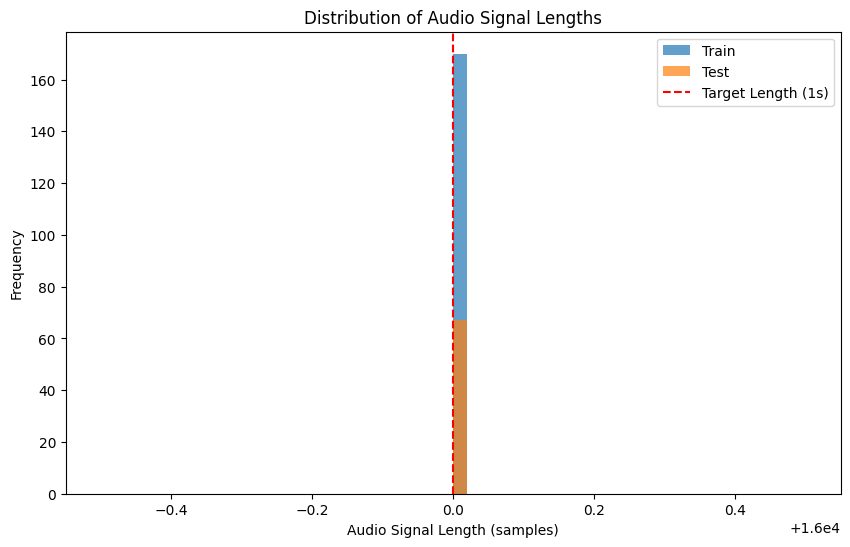

In [9]:
# Calculate lengths of raw audio signals
train_lengths = [len(signal) for signal in train_data]
test_lengths = [len(signal) for signal in test_data]

# Plot histogram of audio lengths
plt.figure(figsize=(10, 6))
plt.hist(train_lengths, bins=50, alpha=0.7, label='Train')
plt.hist(test_lengths, bins=50, alpha=0.7, label='Test')
plt.axvline(16000, color='r', linestyle='--', label='Target Length (1s)')
plt.xlabel("Audio Signal Length (samples)")
plt.ylabel("Frequency")
plt.title("Distribution of Audio Signal Lengths")
plt.legend()
plt.show()


### Mel Spectrograms

The normalization of Mel spectrograms ensures the 128 frequency bins and 32 time steps are scaled consistently across all 210 training samples and 67 testing samples. This prevents the model from focusing on differences in magnitude and encourages it to learn meaningful patterns in the audio features.

In [10]:
def preprocess_audio_data(data, labels, sr=16000, n_mels=128):
    """
    Convert audio waveforms to normalized Mel spectrograms and encode labels.
    """
    features = []
    for signal in data:
        mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to dB scale
        mel_spec_db = (mel_spec_db - np.mean(mel_spec_db)) / np.std(mel_spec_db)  # Normalize
        features.append(mel_spec_db)

    # Convert to numpy arrays
    features = np.array(features)
    features = features.reshape(features.shape[0], features.shape[1], features.shape[2], 1)  # Add channel dimension

    # Encode labels
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    
    return features, encoded_labels, encoder


# Preprocess training and test data
X_train, y_train, encoder = preprocess_audio_data(train_data, train_labels)
X_test, y_test, _ = preprocess_audio_data(test_data, test_labels)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Training data shape: (170, 128, 32, 1)
Testing data shape: (67, 128, 32, 1)


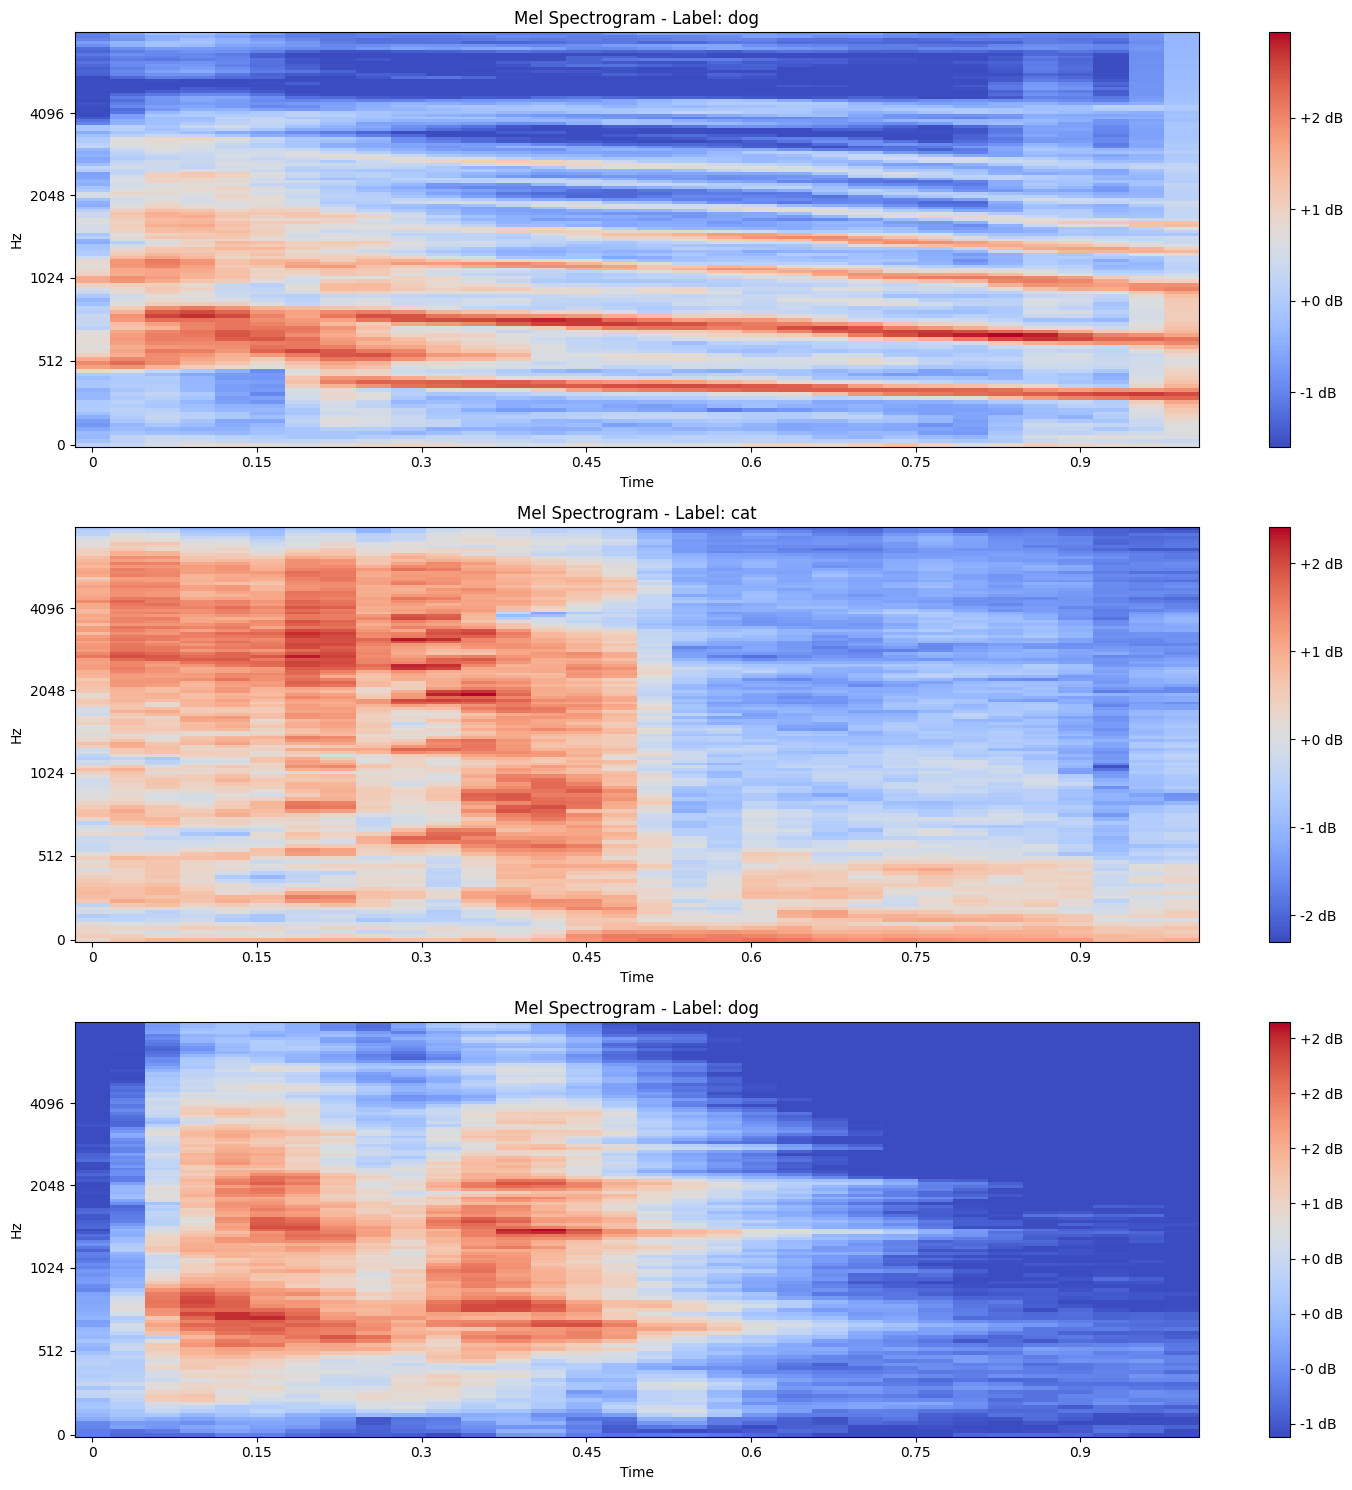

In [11]:
# Visualize Mel spectrograms for a few samples
def plot_mel_spectrograms(data, labels, encoder, num_samples=3):
    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(num_samples):
        mel_spec = data[i].squeeze()  # Remove channel dimension
        label = encoder.inverse_transform([labels[i]])[0]
        plt.subplot(num_samples, 1, i + 1)
        librosa.display.specshow(mel_spec, sr=16000, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Mel Spectrogram - Label: {label}")
        plt.tight_layout()
    plt.show()

# Plot spectrograms for the first few samples in the training data
plot_mel_spectrograms(X_train, y_train, encoder)


We built an LSTM-based model for audio classification to effectively capture the temporal relationships inherent in sequential data like spectrograms. The model includes two stacked LSTM layers, with 128 and 64 units respectively, to learn both short-term and long-term dependencies in the data. Dropout regularization with a rate of 30% was added to prevent overfitting and improve generalization. After the LSTM layers, a dense layer with 64 units and ReLU activation was included to refine the learned features, followed by a single output neuron with a sigmoid activation function to classify the audio as either cat or dog. The model was compiled with the Adam optimizer for efficient training, binary cross-entropy as the loss function for this binary classification task, and accuracy as a key evaluation metric. This architecture balances complexity and performance, making it a strong baseline for processing audio data while minimizing risks of overfitting.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten

def build_model(input_shape):
    """
    Build a sequential LSTM-based model for audio classification.
    """
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification (0 or 1)
    ])
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

# Define the input shape
input_shape = (X_train.shape[1], X_train.shape[2])  # (time steps, features)

# Build and compile the model
model = build_model(input_shape)

# Summary of the model
model.summary()


2025-01-26 13:55:11.950858: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-01-26 13:55:11.950876: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-01-26 13:55:11.950879: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-01-26 13:55:11.950908: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-26 13:55:11.950918: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/hunterjenkins/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Seq

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128, 128)       │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,065 (531.50 KB)

 Trainable params: 136,065 (531.50 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from sklearn.model_selection import train_test_split

# Split the training data
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train_split.shape}")
print(f"Validation data shape: {X_val.shape}")


Training data shape: (136, 128, 32, 1)
Validation data shape: (34, 128, 32, 1)


In [14]:
history = model.fit(X_train_split, y_train_split, 
                    validation_data=(X_val, y_val),
                    epochs=20, 
                    batch_size=32)


Epoch 1/20


2025-01-26 13:55:12.671616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.5058 - loss: 0.6874 - val_accuracy: 0.5294 - val_loss: 0.6849
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6657 - loss: 0.6152 - val_accuracy: 0.6765 - val_loss: 0.6280
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7533 - loss: 0.5435 - val_accuracy: 0.7059 - val_loss: 0.6020
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7514 - loss: 0.4649 - val_accuracy: 0.7059 - val_loss: 0.5472
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7945 - loss: 0.4346 - val_accuracy: 0.7353 - val_loss: 0.5630
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7942 - loss: 0.4089 - val_accuracy: 0.7941 - val_loss: 0.5262
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8549 - loss: 0.3253 - val_accuracy: 0.7647 - val_loss: 0.6041
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8686 - loss: 0.2879 - val_accuracy: 0.7059 - val_loss: 0.6927
Epoch 9/20

This code evaluates the trained model on the test dataset and visualizes the training process to analyze its performance. The evaluation step computes the loss and accuracy of the model on unseen test data, giving an indication of how well it generalizes beyond the training and validation datasets. The loss value measures the model's error, while accuracy indicates the proportion of correct predictions.

The subsequent visualization of training history involves plotting the training and validation accuracy over epochs, providing insights into the model's learning behavior. A steadily increasing accuracy curve indicates effective learning, while a widening gap between training and validation accuracy might suggest overfitting. Similarly, plotting the loss for training and validation helps identify if the model is struggling to converge or overfitting the training data.

These plots are essential for diagnosing potential issues, such as underfitting, overfitting, or stagnation during training, and they guide further optimization of the model architecture or hyperparameters to improve performance.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7137 - loss: 0.5976
Test Loss: 0.5907585620880127
Test Accuracy: 0.7164179086685181


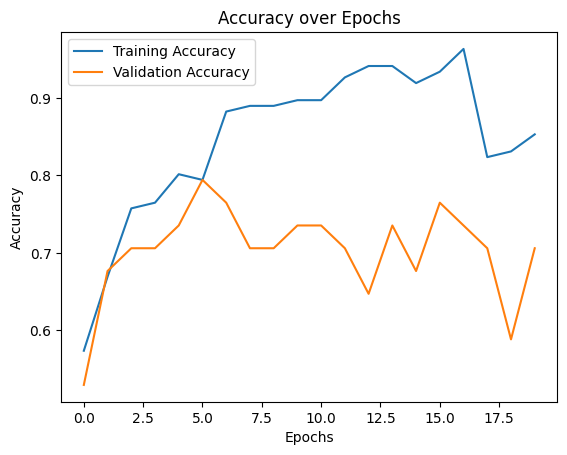

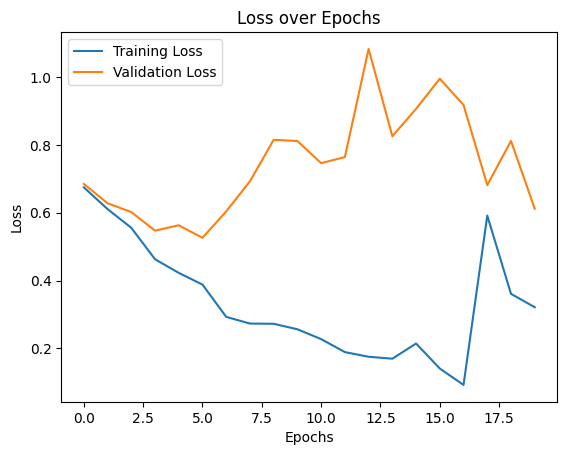

In [15]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.show()



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Classification Report:
              precision    recall  f1-score   support

         cat       0.74      0.79      0.77        39
         dog       0.68      0.61      0.64        28

    accuracy                           0.72        67
   macro avg       0.71      0.70      0.70        67
weighted avg       0.71      0.72      0.71        67



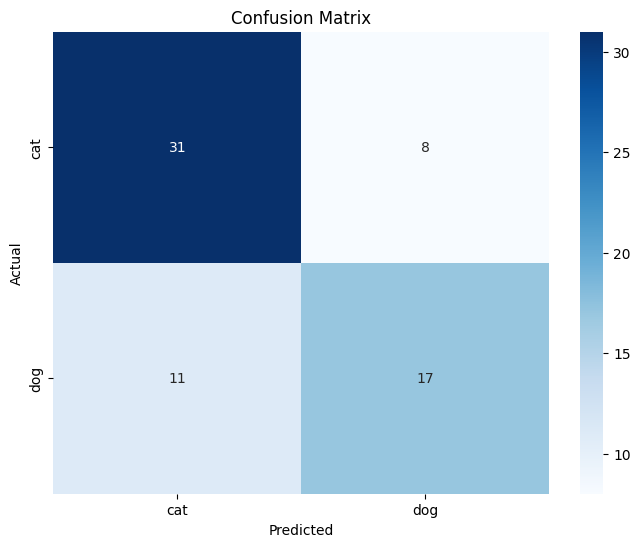

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict on test data
y_pred = (model.predict(X_test) > 0.5).astype('int32')

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


The provided code establishes a pipeline for preprocessing and augmenting audio data, as well as for preparing a dataset for training and testing an audio classification model (e.g., distinguishing between cat and dog sounds). It begins by reading `.wav` audio files using the `read_wav_files` function, which extracts raw waveform signals from the files. The `get_trunk` function takes these waveforms and extracts fixed-length segments, optionally adding a random offset to introduce variation and prevent overfitting. Building on this, the `get_augmented_trunk` function enhances the extracted audio by mixing in waveforms from other samples of the same class, a process that augments the data and makes the model more robust to variability. The `dataset_gen` function is a generator that produces batches of audio data and their corresponding labels for training or testing. It uses the aforementioned trunk extraction functions to prepare augmented batches for training or simple trunks for evaluation. The `load_dataset` function ties everything together by loading `.wav` file paths from a CSV file and extracting, normalizing, and concatenating audio signals into arrays for each category (e.g., `train_cat`, `test_dog`). This normalization process ensures that the audio data is standardized, improving model training stability. Overall, the pipeline integrates data loading, augmentation, and batch generation, making it well-suited for scalable and effective audio classification model development.

In [17]:
def predict_audio_file(file_path, model, encoder, sr=16000, n_mels=128):
    try:
        # Load and preprocess the audio
        signal, _ = librosa.load(file_path, sr=sr)
        mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_db = (mel_spec_db - np.mean(mel_spec_db)) / np.std(mel_spec_db)
        mel_spec_db = mel_spec_db.reshape(1, mel_spec_db.shape[0], mel_spec_db.shape[1], 1)

        # Predict
        prediction = model.predict(mel_spec_db)
        predicted_class = encoder.inverse_transform([int(prediction > 0.5)])[0]
        return predicted_class
    except Exception as e:
        print(f"Error predicting {file_path}: {e}")
        return None


# Path to a new audio file
new_audio_path = "cats_dogs/cat_151.wav"

# Predict the label
predicted_label = predict_audio_file(new_audio_path, model, encoder)
print(f"The predicted label for the audio file {new_audio_path} is: {predicted_label}")


# Path to a new audio file
new_audio_path = "cats_dogs/dog_barking_112.wav"

# Predict the label
predicted_label = predict_audio_file(new_audio_path, model, encoder)
print(f"The predicted label for the audio file {new_audio_path} is: {predicted_label}")


: 